[<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/snntorch_alpha_w.png?raw=true' width="400">](https://github.com/jeshraghian/snntorch/)

# Binarized Spiking Neural Networks
## By Erik Mercado


<a href="https://colab.research.google.com/github/jeshraghian/snntorch/blob/master/examples/tutorial_BSNN.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

[<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/GitHub-Mark-Light-120px-plus.png?raw=true' width="28">](https://github.com/jeshraghian/snntorch/) [<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/GitHub_Logo_White.png?raw=true' width="80">](https://github.com/jeshraghian/snntorch/)


This tutorial is based on the following papers on binarized spiking neural networks. If you find these resources or code useful in your work, please consider citing the following sources:

> <cite> [Jason K. Eshraghian, Xinxin Wang, and Wei D. Lu. "Memristor-based Binarized Spiking Neural Networks: Challenges and Applications". IEEE Nanotechnology Magazine, 16(2) April 2023.](https://ieeexplore.ieee.org/abstract/document/9693512/) </cite>

> <cite> [Jason K. Eshraghian, Max Ward, Emre Neftci, Xinxin Wang, Gregor Lenz, Girish Dwivedi, Mohammed Bennamoun, Doo Seok Jeong, and Wei D. Lu. "Training Spiking Neural Networks Using Lessons From Deep Learning". Proceedings of the IEEE, 111(9) September 2023.](https://ieeexplore.ieee.org/abstract/document/10242251) </cite>

This tutorial will show you how to train a binarized spiking neural networks (BSNNs) in snnTorch. Weights are binarized and forced to take on values $w \in \{-1,+1\}$. Weight binarization is applied during training with a straight-through-estimator to side-step the non-differentiability of binarization. This is distinct to the surrogate gradient applied to the spiking function.

> Note: The model you will train is an emulation of binarized SNNs. I.e., while the weights are constrained to taking on $+1$ and $-1$, they are represented in a full precision format. 

In general, SNNs are thought to potentially improve upon the performance of binarized neural networks because: 1) they can represent data over time, where time cannot be binarized, and 2) because data can be stored in the state of the neuron. They can be difficult to optimize, but there is a lot of space in enabling BSNNs to perform similarly to SNNs.

# 1. Environment Setup


In [ ]:
! pip install snntorch --quiet

In [ ]:
# PyTorch Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.optim import Adam
from torch.utils.data import random_split

# Additional Imports
import snntorch as snn
import matplotlib.pyplot as plt
import numpy as np
import time
import os

# Set the seed for reproducibility of results
torch.manual_seed(0)

# 2. Data Preparation

## Fashion-MNIST (FMNIST) Dataset Overview
- **Total Images:** 70,000 grayscale images
- **Image Dimensions:** 28x28 pixels
- **Categories:** 10 categories of fashion products, with 7,000 images per category

## Dataset Composition
- **Training Set:** 60,000 images
- **Test Set:** 10,000 images

## Training and Validation Split
- **Standard Practice:** Splitting the training set into separate training and validation sets
- **Split Ratio:** 80% for training, 20% for validation
- **In Practice for FMNIST:**
  - **Training Set:** 48,000 images
  - **Validation Set:** 12,000 images
- **Purpose of Split:** Allows for hyperparameter tuning and model validation during training, while keeping the test set separate for final evaluation
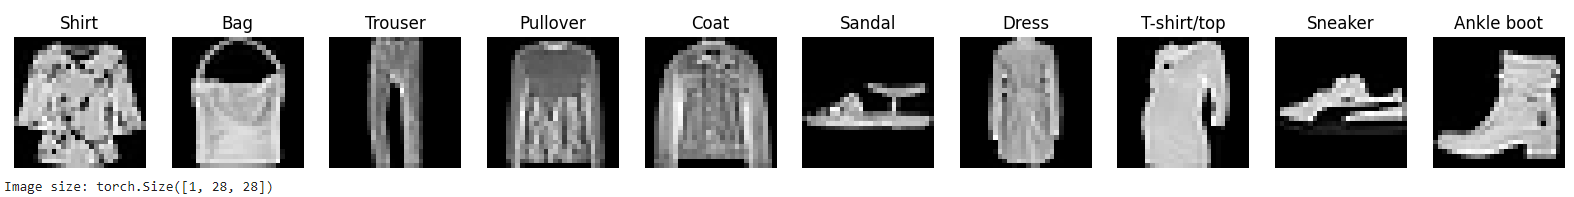

In [ ]:
# Load Fashion-MNIST data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

# Download and load the Fashion-MNIST dataset
train_set = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_set = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Split the train_set into new training and validation sets
train_size = int(0.8 * len(train_set)) # 80% train_set
val_size = len(train_set) - train_size # 20% train_set
train_subset, val_subset = random_split(train_set, [train_size, val_size])

# Create data loaders for the training, validation, and test sets
train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)


In [ ]:
#@title Dataset Visualization Function
def show_img_by_class(data_loader, classes):
    class_images = {}
    class_labels = {}

    # loop through the DataLoader until we find one instance of each class.
    while len(class_images) < len(classes):
        images, labels = next(data_loader)
        for i, label in enumerate(labels):
            if label.item() not in class_images and len(class_images) < len(classes):
                class_images[label.item()] = images[i]
                class_labels[label.item()] = label

    # Set a larger figure size to accommodate the images
    plt.figure(figsize=(20, 20))

    # plot each image and its label
    for i, (label, image) in enumerate(class_images.items()):
        ax = plt.subplot(1, len(classes), i + 1)
        img = image / 2 + 0.5  # Unnormalize
        npimg = img.numpy()
        plt.imshow(npimg.squeeze(), cmap="gray")  # Grayscale images don't need color channel adjustment
        ax.set_title(f"{classes[class_labels[label].item()]}")
        ax.axis("off")

    plt.show()

    # print image size
    print(f"Image size: {images[0].size()}")

# get a batch of training images
data_iter = iter(train_loader)

# classes in Fashion-MNIST
classes = ("T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
           "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot")

show_img_by_class(data_iter, classes)

# 3. Define the BSNN Model


## 3.1 Binarization

Binarization will convert all weights greater than $0$ to $+1$, and all weights less than $0$ to $-1$. This thresholding function is non-differentiable. The following functions show how to separate the binarization in the forward-pass and ignoring the binarization in the backward pass.

- **Method: `forward`**
  - **Purpose:** Performs binarization.
  - **Operation:**
    - `input.sign()`: Computes the sign of each element in the input tensor. Returns 1 for positive values and -1 for negative and zero values.
    - `.clamp(min=-1)`: Ensures the minimum value in the tensor is -1, effectively converting 0s to -1s, as required for binarization.

    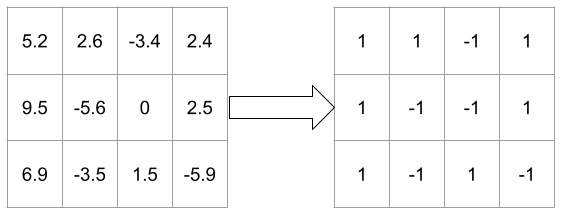



- **Method: `backward`**
  - **Purpose:** Defines the gradient computation for backpropagation in neural networks.
  - **Operation:**
    - `gradient_out.clone()`: Creates a clone of the gradient. This is part of the Straight-Through Estimator (STE) technique, where the gradient is passed unchanged or modified minimally to facilitate backpropagation in binary networks.
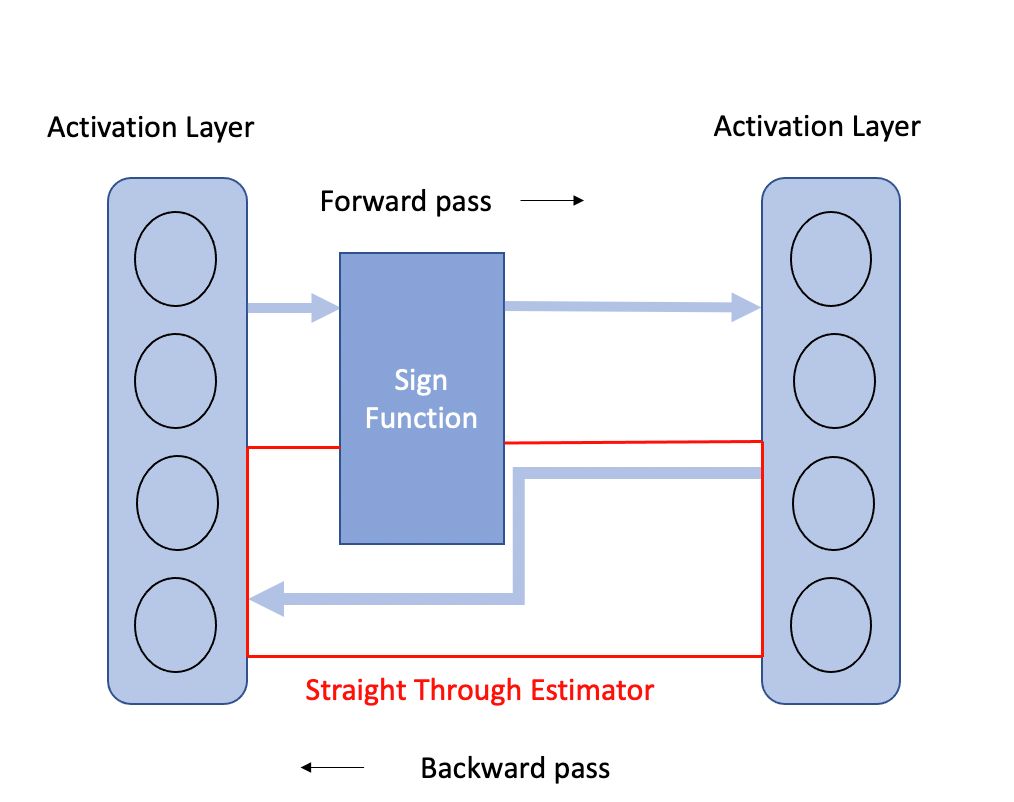


The following function will be applied to various layers in PyTorch.

In [ ]:
class Binarize(Function):
  @staticmethod
  def forward(weight_ref, input):
    return input.sign().clamp(min=-1) # convert input to -1 or 1

  @staticmethod
  def backward(weight_ref, gradient_out):
    gradient_in = gradient_out.clone() # create clone of weights for STE
    return gradient_in


## 3.2 Custom Binary Conv2d Layer

The above function will now be applied to various neural network layer types. 
Note that the full precision weights are stored in the background and all weight updates are applied to these full precision weights. 
Weights are binarized only during the forward-pass in order to generate a loss that is aware of the binarization function.

- **Method: `forward`**
  - **Purpose:** Conv2d With Binarization
  - **Operation:**
    - return a Pytroch Conv Layer with Binarized Weights

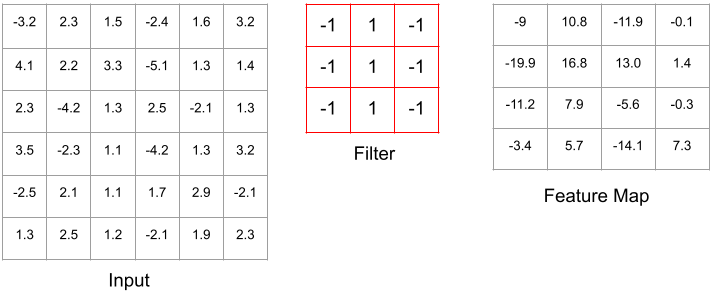

- **Method: `reset_parameters`**
  - **Purpose:** Initalize weights with Xavier normal distribution
  - **Operation:**
    - Initializing the weights to help with vanishing or exploding gradients
    - Mean = 0
    - STD = 1



In [ ]:
class BinaryConv2d(nn.Conv2d):

  def __init__(self, *kargs, **kwargs):
        super(BinaryConv2d, self).__init__(*kargs, **kwargs)

  def forward(self, input):
    binarized_weights = Binarize.apply(self.weight)
    return F.conv2d(input, binarized_weights)

  def reset_parameters(self):
    # Xavier normal initialization
    nn.init.xavier_normal_(self.weight)
    if self.bias is not None:
      # Initialize bias to zero
      nn.init.constant(self.bias, 0)


## 3.3 Custom Binary Linear Layer
- **Method: `forward`**
  - **Purpose:** Fully Connected Layer with Binarization.
  - **Operation:**
    - return a Pytroch Linear Layer with Binarized Weights
    - The output vector represents the activation of each neuron in the binarized linear layer.
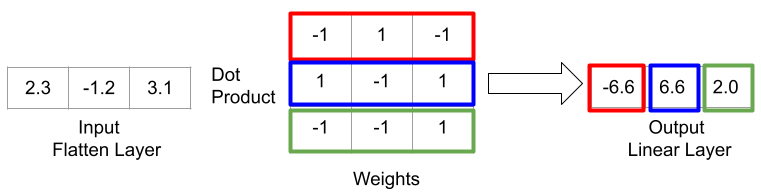


In [ ]:
class BinaryLinear(nn.Linear):

    def forward(self, input):
        bin_weights = Binarize.apply(self.weight)
        if self.bias is None:
            return F.linear(input, bin_weights)
        else:
            return F.linear(input, bin_weights, self.bias)

    def reset_parameters(self):
        # Apply Xavier normal initialization
        torch.nn.init.xavier_normal_(self.weight)
        if self.bias is not None:
            # Initialize bias to zero
            torch.nn.init.constant_(self.bias, 0)


## 3.4 Configuration
Define the hyperparameters for the model and training loop.

In [ ]:
config = {
    # SNN
    "threshold1": 2.3599835635698114,
    "threshold2": 7.985043705972782,
    "threshold3": 3.849629060468402,
    "beta": 0.44154740154430405,
    "num_steps": 10,

    # Network
    "batch_norm": True,
    "dropout": 0.3276864426153669,

    # Hyper Params
    "lr": 0.00713202055922571,

    # Early Stopping
    "min_delta": 1e-6,
    "patience_es": 20,

    # Training
    "epochs": 100
}

## 3.5 BSNN Architecture
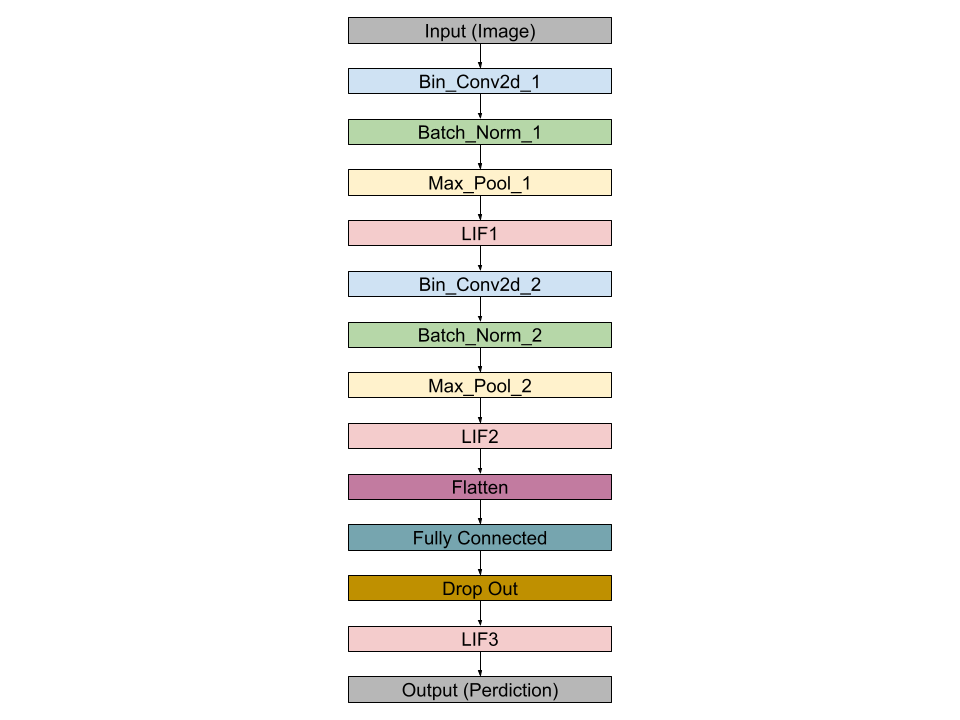

In [ ]:
class BSNN(nn.Module):
  def __init__(self, config):
    super(BSNN, self).__init__()

    # Initialize configuration parameters
      # LIF
    self.thresh1 = config["threshold1"]
    self.thresh2 = config["threshold2"]
    self.thresh3 = config["threshold3"]
    self.beta = config["beta"]
    self.num_steps = config["num_steps"]

      # Hyper Params for Layers
    self.batch_norm = config["batch_norm"]
    self.dropout_percent = config["dropout"]

      # Network Layers
    self.bin_conv_1 = BinaryConv2d(in_channels=1, out_channels=16, kernel_size=3, padding="same", bias=False)
    self.batch_norm_1 = nn.BatchNorm2d(num_features=16)
    self.max_pool_1 = nn.MaxPool2d(kernel_size=2)
    self.lif1 = snn.Leaky(beta=self.beta, threshold=self.thresh1)

    self.bin_conv_2 = BinaryConv2d(in_channels=16, out_channels=32, kernel_size=3, padding="same", bias=False)
    self.batch_norm_2 = nn.BatchNorm2d(num_features=32)
    self.max_pool_2 = nn.MaxPool2d(kernel_size=2)
    self.lif2 = snn.Leaky(beta=self.beta, threshold=self.thresh2)

    self.flatten = nn.Flatten()
    self.bin_fully_connected_1 = BinaryLinear(in_features=32*5*5, out_features=10)
    self.dropout = nn.Dropout(self.dropout_percent)
    self.lif3 = snn.Leaky(beta=self.beta, threshold=self.thresh3)


    # Forward Pass
  def forward(self, inpt):
    mem1 = self.lif1.init_leaky()
    mem2 = self.lif2.init_leaky()
    mem3 = self.lif3.init_leaky()

    spike3_rec = []
    mem3_rec = []

    for step in range(self.num_steps):
      current1 = self.bin_conv_1(inpt)
      current1 = self.batch_norm_1(current1) if self.batch_norm else current1
      current1 = self.max_pool_1(current1)
      spike1, mem1 = self.lif1(current1, mem1)

      current2 = self.bin_conv_2(spike1)
      current2 = self.batch_norm_2(current2) if self.batch_norm else current2
      current2 = self.max_pool_2(current2)
      spike2, mem2 = self.lif2(current2, mem2)

      current3 = self.flatten(spike2)
      current3 = self.bin_fully_connected_1(current3)
      current3 = self.dropout(current3)
      spike3, mem3 = self.lif3(current3, mem3)

      spike3_rec.append(spike3)
      mem3_rec.append(mem3)

    return torch.stack(spike3_rec, dim=0), torch.stack(mem3_rec, dim=0)



# 4. Model Training Setup


## 4.1 Early Stopping
Use early stopping during the training loop. If the model doesn't improve performance after 20 epochs by default, then use the last best performant model.


In [ ]:
class EarlyStopping:
    def __init__(self, patience=config["patience_es"], min_delta=config["min_delta"]):
        # Early stops the training if validation loss doesn't improve after a given patience.
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_score is None:
            self.best_score = val_loss
        elif val_loss > self.best_score - self.min_delta:
            self.counter += 1
            print(f"Earlystop {self.counter}/{self.patience}\n")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.counter = 0

## 4.2 Training Set-Up

In [ ]:
# Model initialization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BSNN(config).to(device)

# Optimizer and Loss Function
optimizer = Adam(model.parameters(), lr=config["lr"])
criterion = nn.CrossEntropyLoss()

# Early Stopping
early_stopping = EarlyStopping(patience=config["patience_es"], min_delta=config["min_delta"])

# 5. Training Loop


### Training Function

Below is a training loop. We will train for one epoch initially, exposing our network to each sample of data once. We can change the number of epochs to run more training loops.

In [ ]:
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for data, targets in train_loader:
        data, targets = data.to(device), targets.to(device)

        optimizer.zero_grad()
        spike_out, _ = model(data)
        output = spike_out.sum(dim=0)
        loss = criterion(output, targets)
        running_loss += loss.item()

        _, predicted_train = torch.max(output.data, 1)
        total_train += targets.size(0)
        correct_train += (predicted_train == targets).sum().item()

        loss.backward()
        optimizer.step()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    return train_loss, train_accuracy


### Validation Function

In [ ]:
def validate(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for data, targets in val_loader:
            data, targets = data.to(device), targets.to(device)
            spike_out, _ = model(data)
            output = spike_out.sum(dim=0)
            loss = criterion(output, targets)
            val_loss += loss.item()

            _, predicted_val = torch.max(output.data, 1)
            total_val += targets.size(0)
            correct_val += (predicted_val == targets).sum().item()

    val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    return val_loss, val_accuracy


### Training Loop

The function below iterates over all minibatches to obtain a measure of accuracy over all the samples in the test set.

In [ ]:
train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []
best_val_accuracy = 0
model_path = "best_BSNN_model.pth"

for epoch in range(config["epochs"]):
    train_loss, train_accuracy = train(model, train_loader, optimizer, criterion, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    val_loss, val_accuracy = validate(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch: {epoch + 1}, Training Loss: {train_loss:.5f}, Training Accuracy: {train_accuracy:.2f}%, Validation Loss: {val_loss:.5f}, Validation Accuracy: {val_accuracy:.2f}%\n")

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), model_path)
        print(f"Saved model with improved validation accuracy: {val_accuracy:.2f}% \n")

    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("\nEarly stopping triggered")
        break

# 6. Visualization and Analysis


Plotting training loss: loss curves are noisy because the losses are tracked at every iteration instead of an average of multiple iterations.

In [ ]:
# Plotting training, validation, and test losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting training, validation, and test accuracies
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()


# 7. Testing
* Run the testing dataset through the model.
* Collect and display metrics such as accuracy, loss

In [ ]:
def test(model, test_loader, criterion, device, model_path="best_BSNN_model.pth"):

    # Initialize variables for test loss and accuracy
    test_loss = 0.0
    correct_test = 0
    total_test = 0

    # Restore best BSNN Model
    if os.path.isfile(model_path):
        model.load_state_dict(torch.load(model_path))
        print(f"Loaded saved model from {model_path}\n")

    # Switch model to evaluation mode
    model.eval()

    # Iterate over the test data
    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device)

            # Forward pass
            outputs, _ = model(data)  # Modify according to your model's output
            outputs = outputs.mean(dim=0)

            # Calculate loss
            loss = criterion(outputs, targets)
            test_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_test += targets.size(0)
            correct_test += (predicted == targets).sum().item()

    # Calculate average loss and accuracy
    test_loss /= len(test_loader)
    test_accuracy = 100 * correct_test / total_test

    return test_loss, test_accuracy


In [ ]:
test_loss, test_accuracy = test(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Conclusion

Accuracy should be reaching reasonably good numbers despite the severe constraint on weights. Caveat: it can take a while to find the optimal hyperparameters to use when training BSNNs. 

If you like this project, please consider starring ⭐ the repo on GitHub as it is the easiest and best way to support it.


# Additional Resources
* [Check out the snnTorch GitHub project here.](https://github.com/jeshraghian/snntorch)

* More detail on BSNNs can be found in the corresponding paper here: [Jason K. Eshraghian, Xinxin Wang, and Wei D. Lu. "Memristor-based Binarized Spiking Neural Networks: Challenges and Applications". IEEE Nanotechnology Magazine, 16(2) April 2023.](https://ieeexplore.ieee.org/abstract/document/9693512/)